In [1]:
from test_examples import *

# Test 1

In [ ]:
test1 = single_static_obstacle()
test1.test()

In [ ]:
test1.print_plots()

In [ ]:
test1.save_animation()

# Test 2

In [ ]:
test2 = double_moving_obstacles()
test2.test()

In [ ]:
test2.print_plots()

In [ ]:
test2.save_animation(filename="test2")

In [ ]:
test2.save_animation(filename="test2-time_frames", best_for_time=True)

# Test 3 - keyhole

In [ ]:
test3 = keyhole_obstacle_problem()


In [ ]:
test3.test()

In [ ]:
test3.print_plots()

In [ ]:
test3.save_animation(filename="keyhole")


In [ ]:
test3.save_animation(filename="keyhole-time_frames", best_for_time=True)

# Test 4, 5 - random problem

In [ ]:
test4 = multi_obstacle_random_target()
test4.test()
test4.print_plots()

In [ ]:
test4.save_animation(filename="multi4")

In [ ]:
test4.save_animation(filename="multi4-timeframes", best_for_time=True)

In [ ]:
test5 = multi_obstacle_random_target()
test5.test()
test5.print_plots

In [ ]:
test5.save_animation(filename="multi5")

In [ ]:
test5.save_animation(filename="multi5", best_for_time=True)

# Tests 6 - 8

In [2]:
def test_random(n):
    print(f"Test {n}")
    test = multi_obstacle_random_target()
    test.test()
    try:
        test.print_plots()
        test.save_animation(filename=f"multi{n}")
        test.save_animation(filename=f"multi{n}-timeframes", best_for_time=True)
        return test
    except:
        return test


In [ ]:
test_random(6)

In [ ]:
test_random(7)

In [ ]:
test_random(8)

Test 21


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.54963438, mean score = -17.57591998.
Iteration 0001 : best score = -0.50844186, mean score = -8.60244778.
Iteration 0002 : best score = -0.00186792, mean score = -4.80134077.
Iteration 0003 : best score = -0.00186792, mean score = -2.76951974.
Iteration 0004 : best score = -0.00186792, mean score = -1.68570495.
Iteration 0005 : best score = -0.00186792, mean score = -1.41893744.
Iteration 0006 : best score = -0.00186792, mean score = -1.03130859.
Iteration 0007 : best score = -0.00073174, mean score = -0.77535878.
Iteration 0008 : best score = -0.00033947, mean score = -0.64959043.
Iteration 0009 : best score = -0.00033947, mean score = -0.46002575.
Iteration 0010 : best score = -0.00024397, mean score = -0.33340500.
Iteration 0011 : best score = -0.00024397, mean score = -0.26701182.
Iteration 0012 : best score = -0.00015935, mean score = -0.19085462.
Iteration 0013 : best score = -0.00001842, mean score = -0.13021567.
Iteration 0014 : best score = -0.

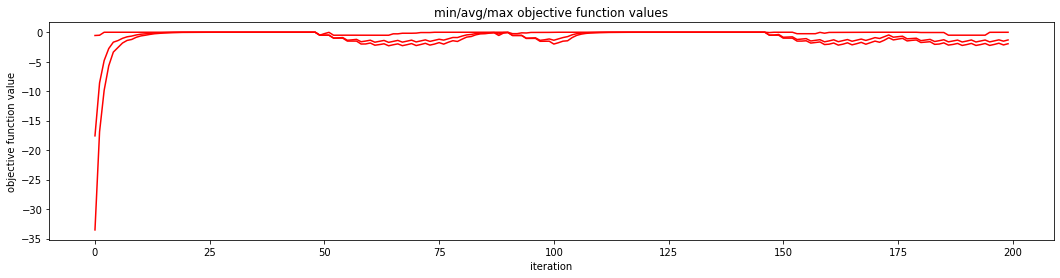

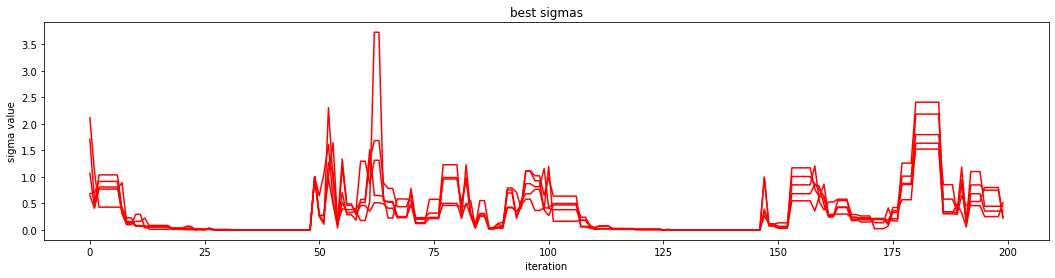

{'start_point': (0, 0), 'xlim': (-7.851083973333464, 7.851083973333464), 'ylim': (-7.851083973333464, 7.851083973333464), 'target_point': (1.816374208280319, -6.120762397146255), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...

AttributeError: 'list' object has no attribute 'set_data'

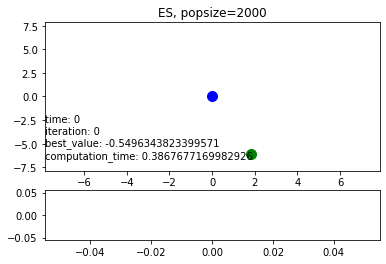

In [3]:
test_random(21)

# Tests 9 - 12

Test 9


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.06534373, mean score = -12.97306230.
Iteration 0001 : best score = -0.01512371, mean score = -7.29744279.
Iteration 0002 : best score = -0.00480966, mean score = -5.01317377.
Iteration 0003 : best score = -0.00480966, mean score = -3.68876283.
Iteration 0004 : best score = -0.00480966, mean score = -2.88170317.
Iteration 0005 : best score = -0.00480966, mean score = -2.60224578.
Iteration 0006 : best score = -0.00480966, mean score = -2.14655319.
Iteration 0007 : best score = -0.00480966, mean score = -1.83208758.
Iteration 0008 : best score = -0.00353954, mean score = -1.78540547.
Iteration 0009 : best score = -0.00353954, mean score = -1.56843369.
Iteration 0010 : best score = -0.00353954, mean score = -1.37012587.
Iteration 0011 : best score = -0.00353954, mean score = -1.36800928.
Iteration 0012 : best score = -0.00071433, mean score = -1.19027893.
Iteration 0013 : best score = -0.00071433, mean score = -1.03723619.
Iteration 0014 : best score = -0.

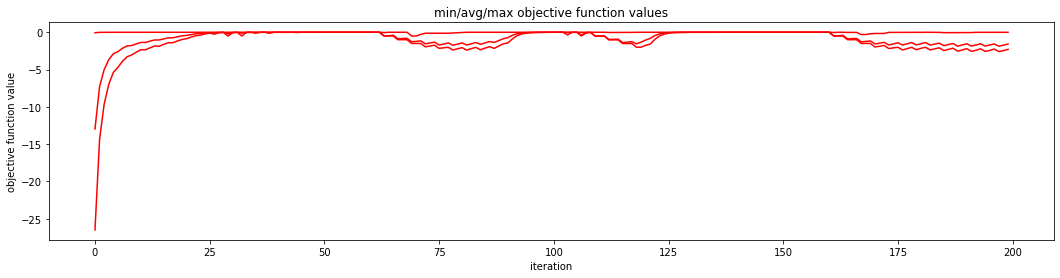

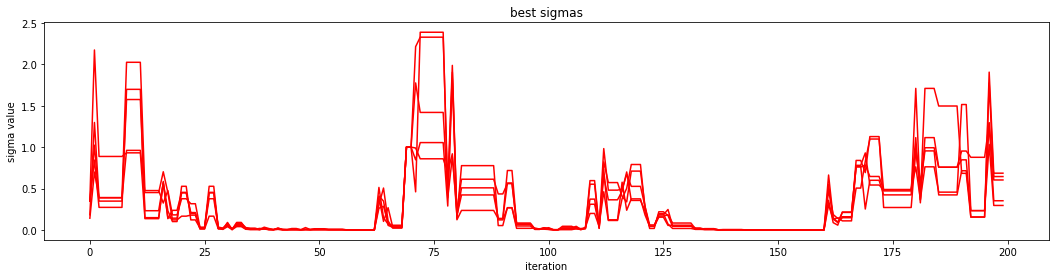

{'start_point': (0, 0), 'xlim': (-9.147768741881531, 9.147768741881531), 'ylim': (-9.147768741881531, 9.147768741881531), 'target_point': (0.022896957246421934, -5.392656037392117), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-9.147768741881531, 9.147768741881531), 'ylim': (-9.147768741881531, 9.147768741881531), 'target_point': (0.022896957246421934, -5.392656037392117), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


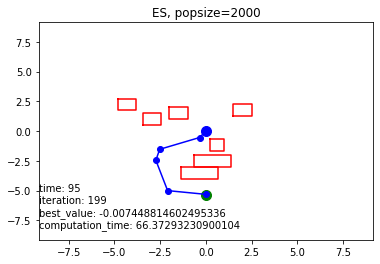

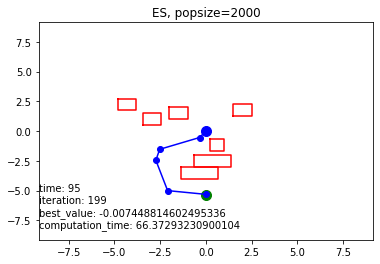

In [4]:
test_random(9)

Test 10


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.16195998, mean score = -24.45730193.
Iteration 0001 : best score = -0.06734961, mean score = -12.68952504.
Iteration 0002 : best score = -0.06734961, mean score = -7.41543011.
Iteration 0003 : best score = -0.01871166, mean score = -4.30261122.
Iteration 0004 : best score = -0.00870108, mean score = -2.79225321.
Iteration 0005 : best score = -0.00870108, mean score = -2.14430458.
Iteration 0006 : best score = -0.00099251, mean score = -1.67842665.
Iteration 0007 : best score = -0.00099251, mean score = -1.37808132.
Iteration 0008 : best score = -0.00870108, mean score = -1.21005917.
Iteration 0009 : best score = -0.00171592, mean score = -1.03070133.
Iteration 0010 : best score = -0.00171592, mean score = -0.89945272.
Iteration 0011 : best score = -0.00171592, mean score = -0.86576862.
Iteration 0012 : best score = -0.00171592, mean score = -0.76032692.
Iteration 0013 : best score = -0.00100473, mean score = -0.65000616.
Iteration 0014 : best score = -0

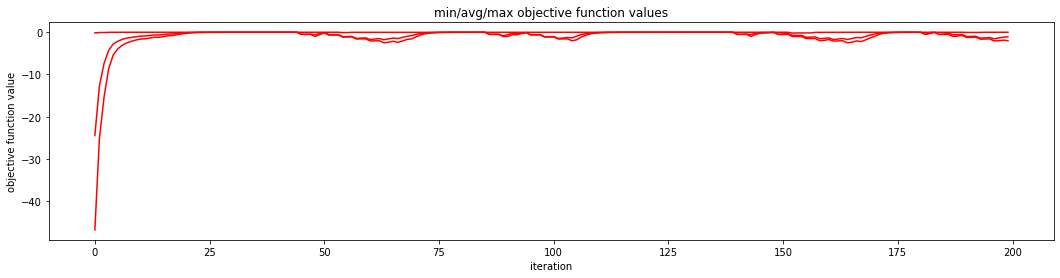

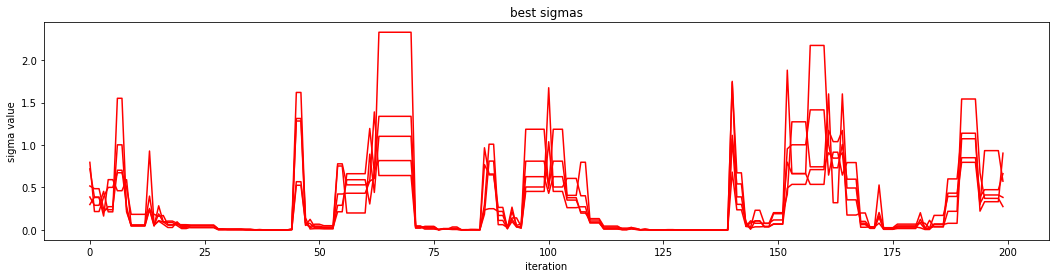

{'start_point': (0, 0), 'xlim': (-10.551487135962526, 10.551487135962526), 'ylim': (-10.551487135962526, 10.551487135962526), 'target_point': (-0.5188447082750951, -7.5064608806096045), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-10.551487135962526, 10.551487135962526), 'ylim': (-10.551487135962526, 10.551487135962526), 'target_point': (-0.5188447082750951, -7.5064608806096045), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


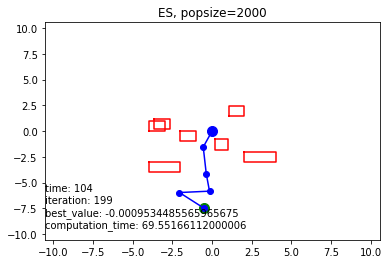

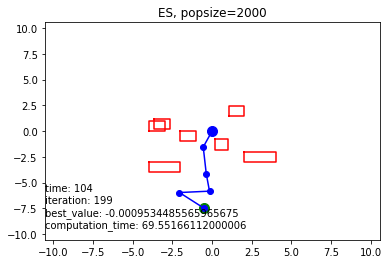

In [5]:
test_random(10)

Test 11


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.06981314, mean score = -20.35195093.
Iteration 0001 : best score = -0.00967411, mean score = -10.50202600.
Iteration 0002 : best score = -0.00660411, mean score = -6.42879133.
Iteration 0003 : best score = -0.00660411, mean score = -3.74267282.
Iteration 0004 : best score = -0.00660411, mean score = -2.26425588.
Iteration 0005 : best score = -0.00660411, mean score = -1.99362362.
Iteration 0006 : best score = -0.00660411, mean score = -1.51890390.
Iteration 0007 : best score = -0.00472608, mean score = -1.17160896.
Iteration 0008 : best score = -0.00008579, mean score = -1.10366050.
Iteration 0009 : best score = -0.00008579, mean score = -0.81371692.
Iteration 0010 : best score = -0.00008579, mean score = -0.57219101.
Iteration 0011 : best score = -0.00008579, mean score = -0.41086884.
Iteration 0012 : best score = -0.00008579, mean score = -0.30225178.
Iteration 0013 : best score = -0.00008579, mean score = -0.22338622.
Iteration 0014 : best score = -0

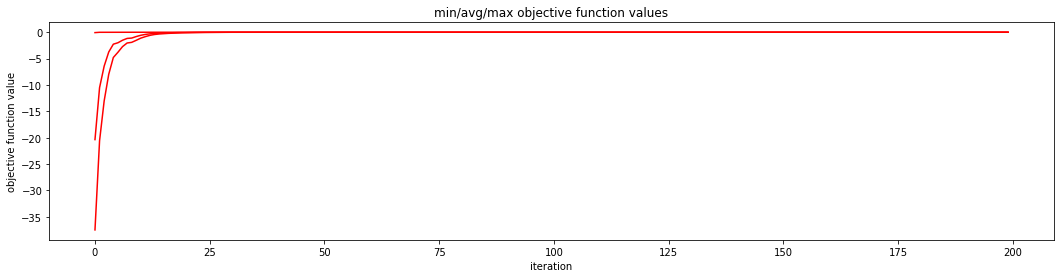

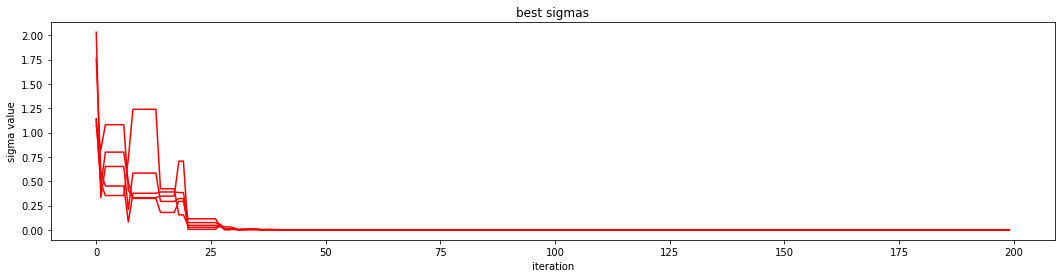

{'start_point': (0, 0), 'xlim': (-8.325408564306255, 8.325408564306255), 'ylim': (-8.325408564306255, 8.325408564306255), 'target_point': (1.7226025380485854, 6.68465477076637), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-8.325408564306255, 8.325408564306255), 'ylim': (-8.325408564306255, 8.325408564306255), 'target_point': (1.7226025380485854, 6.68465477076637), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


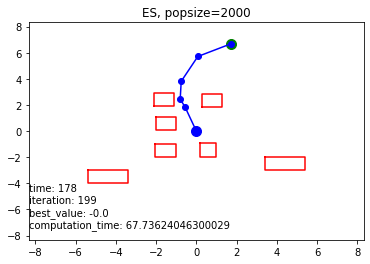

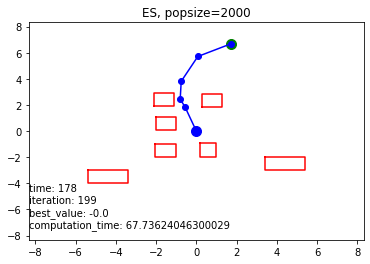

In [6]:
test_random(11)

Test 12


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.00871499, mean score = -7.67079386.
Iteration 0001 : best score = -0.00514106, mean score = -3.31790252.
Iteration 0002 : best score = -0.02051182, mean score = -2.20510189.
Iteration 0003 : best score = -0.00447707, mean score = -1.59953552.
Iteration 0004 : best score = -0.00447707, mean score = -1.25608136.
Iteration 0005 : best score = -0.01433040, mean score = -1.31048101.
Iteration 0006 : best score = -0.00033646, mean score = -1.10654334.
Iteration 0007 : best score = -0.00033646, mean score = -0.93237148.
Iteration 0008 : best score = -0.00518844, mean score = -1.01301197.
Iteration 0009 : best score = -0.00030333, mean score = -0.84288350.
Iteration 0010 : best score = -0.00030333, mean score = -0.69017056.
Iteration 0011 : best score = -0.01625253, mean score = -0.65743838.
Iteration 0012 : best score = -0.01180052, mean score = -0.48941931.
Iteration 0013 : best score = -0.01180052, mean score = -0.35229267.
Iteration 0014 : best score = -0.0

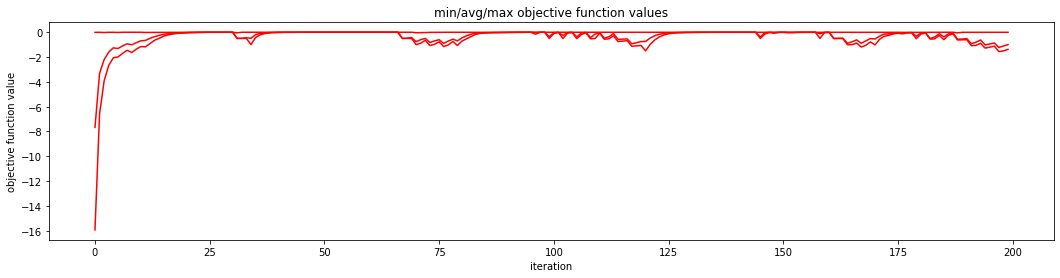

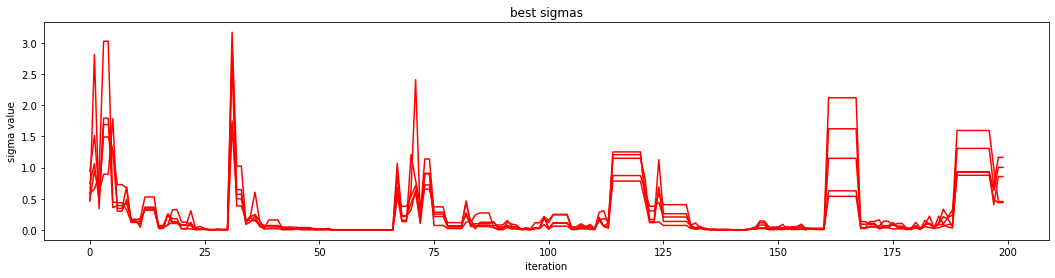

{'start_point': (0, 0), 'xlim': (-6.442860302671503, 6.442860302671503), 'ylim': (-6.442860302671503, 6.442860302671503), 'target_point': (-1.8934904498595513, 3.9029319374432196), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-6.442860302671503, 6.442860302671503), 'ylim': (-6.442860302671503, 6.442860302671503), 'target_point': (-1.8934904498595513, 3.9029319374432196), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


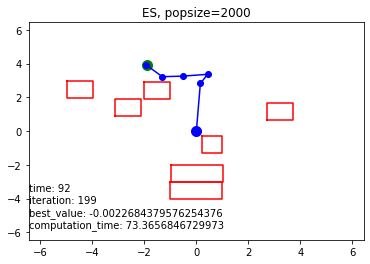

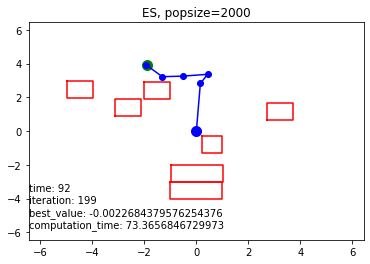

In [7]:
test_random(12)

Test 13


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.24470386, mean score = -23.97109984.
Iteration 0001 : best score = -0.08470092, mean score = -14.24998274.
Iteration 0002 : best score = -0.01417889, mean score = -9.31292740.
Iteration 0003 : best score = -0.01417889, mean score = -5.78248813.
Iteration 0004 : best score = -0.01417889, mean score = -3.37038602.
Iteration 0005 : best score = -0.01417889, mean score = -2.67869444.
Iteration 0006 : best score = -0.00379796, mean score = -1.96395874.
Iteration 0007 : best score = -0.00379796, mean score = -1.51094188.
Iteration 0008 : best score = -0.01154141, mean score = -1.66392530.
Iteration 0009 : best score = -0.01154141, mean score = -1.44283358.
Iteration 0010 : best score = -0.01079052, mean score = -1.25422906.
Iteration 0011 : best score = -0.00676204, mean score = -1.48382912.
Iteration 0012 : best score = -0.00676204, mean score = -1.29647826.
Iteration 0013 : best score = -0.00676204, mean score = -1.12023932.
Iteration 0014 : best score = -0

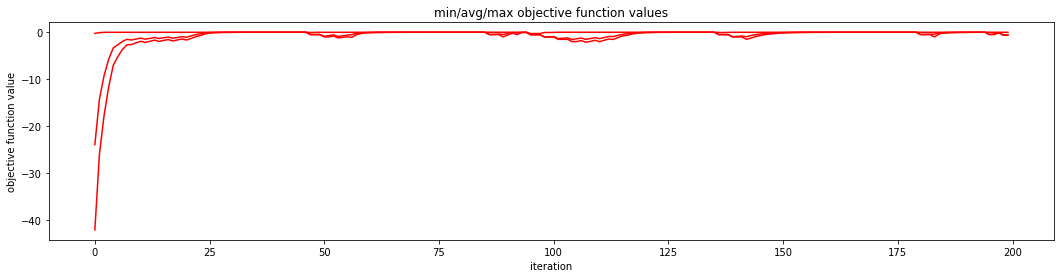

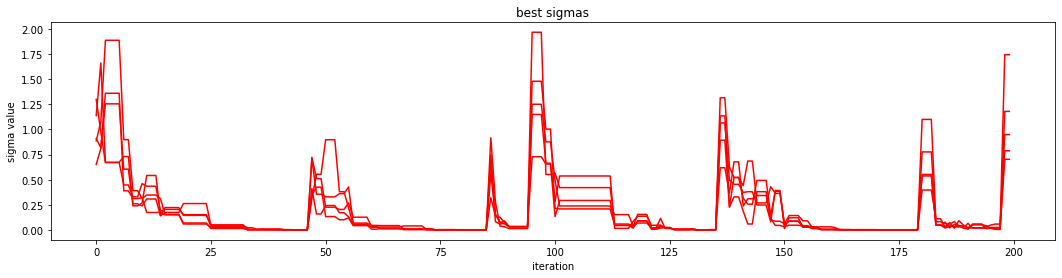

{'start_point': (0, 0), 'xlim': (-8.464285551905306, 8.464285551905306), 'ylim': (-8.464285551905306, 8.464285551905306), 'target_point': (-5.6651782402871085, -4.044796749759961), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-8.464285551905306, 8.464285551905306), 'ylim': (-8.464285551905306, 8.464285551905306), 'target_point': (-5.6651782402871085, -4.044796749759961), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


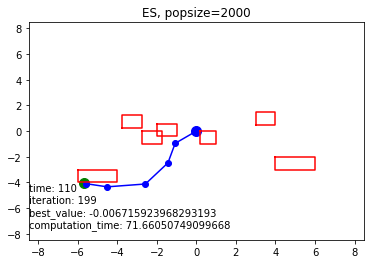

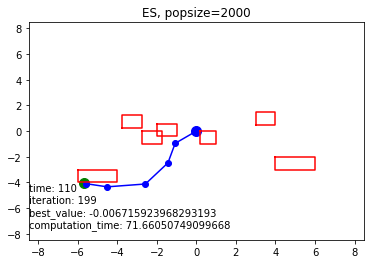

In [8]:
test_random(13)

# Tests 14 - 20

Test 14


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.22708338, mean score = -15.05925872.
Iteration 0001 : best score = -0.08194977, mean score = -7.77995208.
Iteration 0002 : best score = -0.08194977, mean score = -5.27840414.
Iteration 0003 : best score = -0.08194977, mean score = -3.92911075.
Iteration 0004 : best score = -0.08194977, mean score = -3.12728108.
Iteration 0005 : best score = -0.08580862, mean score = -2.94430013.
Iteration 0006 : best score = -0.02228938, mean score = -2.51333638.
Iteration 0007 : best score = -0.02228938, mean score = -2.21112457.
Iteration 0008 : best score = -0.02228938, mean score = -2.36558252.
Iteration 0009 : best score = -0.02228938, mean score = -2.12068255.
Iteration 0010 : best score = -0.01740480, mean score = -1.90981627.
Iteration 0011 : best score = -0.01740480, mean score = -2.12817595.
Iteration 0012 : best score = -0.01740480, mean score = -1.94278545.
Iteration 0013 : best score = -0.00467103, mean score = -1.76601038.
Iteration 0014 : best score = -0.

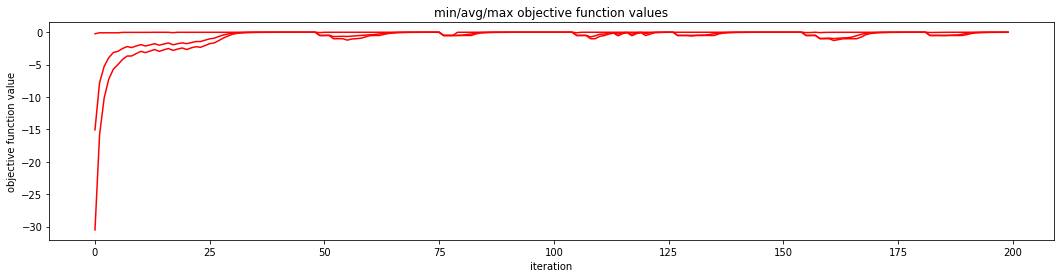

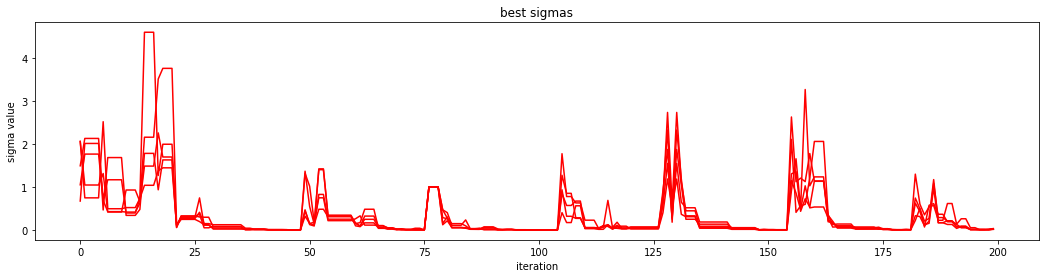

{'start_point': (0, 0), 'xlim': (-9.55584223002707, 9.55584223002707), 'ylim': (-9.55584223002707, 9.55584223002707), 'target_point': (-1.704716408779638, 5.493570613262255), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-9.55584223002707, 9.55584223002707), 'ylim': (-9.55584223002707, 9.55584223002707), 'target_point': (-1.704716408779638, 5.493570613262255), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


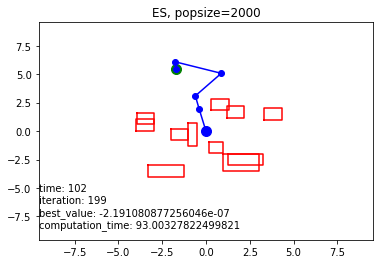

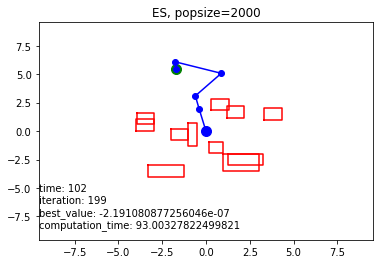

In [3]:
test_random(14)

Test 15


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.00912649, mean score = -5.10455149.
Iteration 0001 : best score = -0.00912649, mean score = -2.82384528.
Iteration 0002 : best score = -0.00543375, mean score = -2.28081328.
Iteration 0003 : best score = -0.00543375, mean score = -1.78978472.
Iteration 0004 : best score = -0.00543375, mean score = -1.50121808.
Iteration 0005 : best score = -0.00543375, mean score = -1.63624096.
Iteration 0006 : best score = -0.00543375, mean score = -1.39490037.
Iteration 0007 : best score = -0.00543375, mean score = -1.21118398.
Iteration 0008 : best score = -0.00543375, mean score = -1.42163510.
Iteration 0009 : best score = -0.00543375, mean score = -1.25154387.
Iteration 0010 : best score = -0.00543375, mean score = -1.10672223.
Iteration 0011 : best score = -0.01112686, mean score = -1.31680710.
Iteration 0012 : best score = -0.01112686, mean score = -1.16053789.
Iteration 0013 : best score = -0.01112686, mean score = -1.01648313.
Iteration 0014 : best score = -0.0

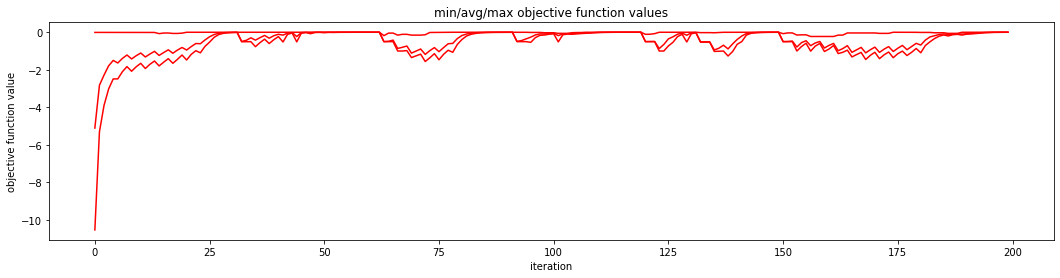

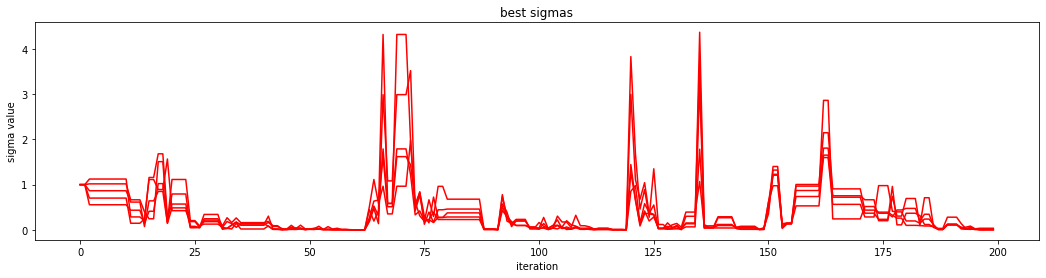

{'start_point': (0, 0), 'xlim': (-7.730102884091489, 7.730102884091489), 'ylim': (-7.730102884091489, 7.730102884091489), 'target_point': (1.8616796569320408, -1.9652771948781158), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-7.730102884091489, 7.730102884091489), 'ylim': (-7.730102884091489, 7.730102884091489), 'target_point': (1.8616796569320408, -1.9652771948781158), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


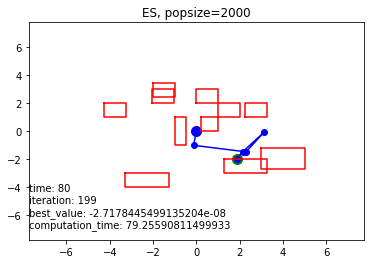

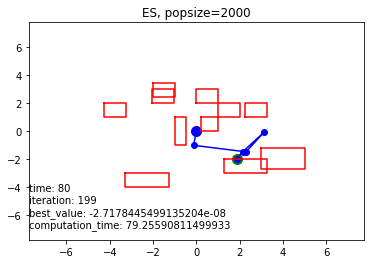

In [4]:
test_random(15)

Test 16


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.46736369, mean score = -37.14657299.
Iteration 0001 : best score = -0.10861699, mean score = -17.72101835.
Iteration 0002 : best score = -0.50138340, mean score = -9.96100465.
Iteration 0003 : best score = -0.03533412, mean score = -5.31931922.
Iteration 0004 : best score = -0.00465657, mean score = -3.00970383.
Iteration 0005 : best score = -0.04050957, mean score = -2.69373539.
Iteration 0006 : best score = -0.04050957, mean score = -2.20116762.
Iteration 0007 : best score = -0.04050957, mean score = -1.79946983.
Iteration 0008 : best score = -0.04050957, mean score = -1.95759575.
Iteration 0009 : best score = -0.03375367, mean score = -1.72015780.
Iteration 0010 : best score = -0.03375367, mean score = -1.54261303.
Iteration 0011 : best score = -0.00342808, mean score = -1.78655720.
Iteration 0012 : best score = -0.00342808, mean score = -1.57321868.
Iteration 0013 : best score = -0.00342808, mean score = -1.37814201.
Iteration 0014 : best score = -0

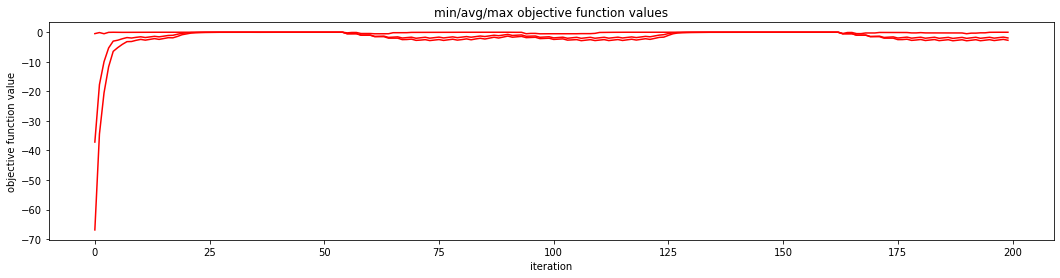

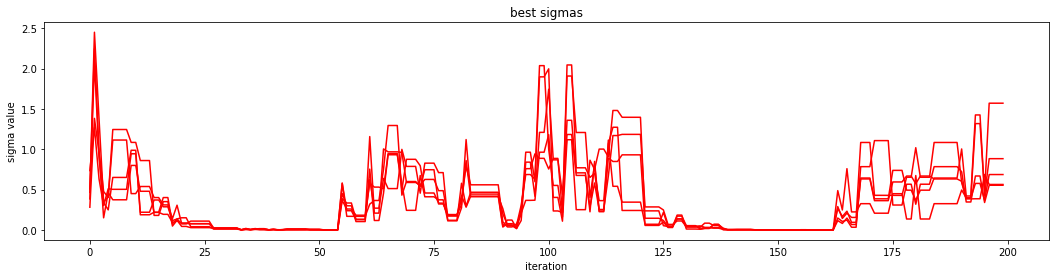

{'start_point': (0, 0), 'xlim': (-10.869266550221143, 10.869266550221143), 'ylim': (-10.869266550221143, 10.869266550221143), 'target_point': (6.50923199184731, -6.549397938428434), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-10.869266550221143, 10.869266550221143), 'ylim': (-10.869266550221143, 10.869266550221143), 'target_point': (6.50923199184731, -6.549397938428434), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


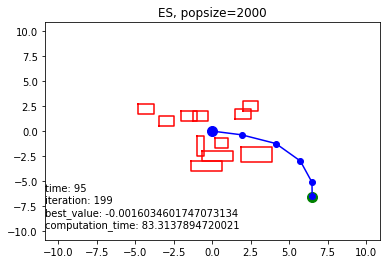

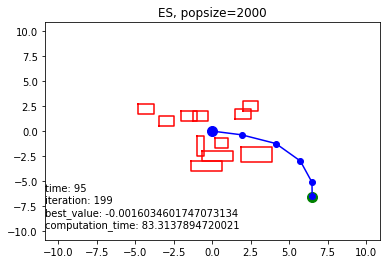

In [5]:
test_random(16)

Test 17


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.50798427, mean score = -10.54916800.
Iteration 0001 : best score = -0.50095865, mean score = -5.75712737.
Iteration 0002 : best score = -0.01132455, mean score = -3.60698814.
Iteration 0003 : best score = -0.00189196, mean score = -2.09302450.
Iteration 0004 : best score = -0.00189196, mean score = -1.26697320.
Iteration 0005 : best score = -0.00164792, mean score = -0.93611549.
Iteration 0006 : best score = -0.00164792, mean score = -0.66632030.
Iteration 0007 : best score = -0.00065705, mean score = -0.49691434.
Iteration 0008 : best score = -0.00101910, mean score = -0.45032326.
Iteration 0009 : best score = -0.00101910, mean score = -0.35549861.
Iteration 0010 : best score = -0.00101910, mean score = -0.27609611.
Iteration 0011 : best score = -0.00108443, mean score = -0.27857008.
Iteration 0012 : best score = -0.00002492, mean score = -0.21199817.
Iteration 0013 : best score = -0.00002492, mean score = -0.16376831.
Iteration 0014 : best score = -0.

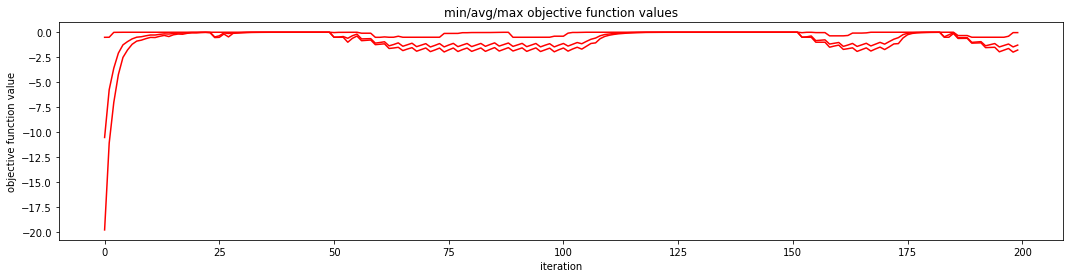

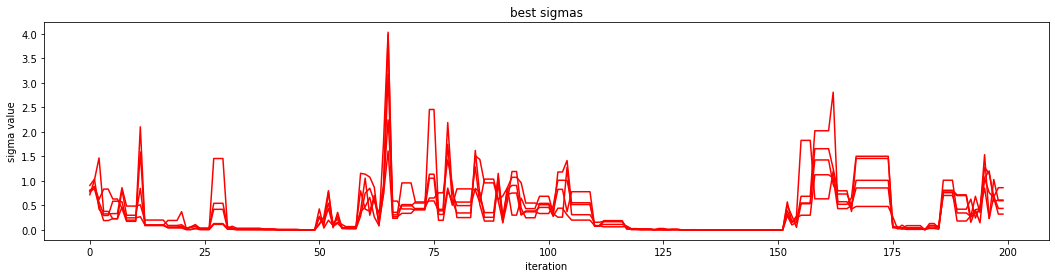

{'start_point': (0, 0), 'xlim': (-6.396550278281899, 6.396550278281899), 'ylim': (-6.396550278281899, 6.396550278281899), 'target_point': (-0.6744300095382068, -4.825270401560883), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-6.396550278281899, 6.396550278281899), 'ylim': (-6.396550278281899, 6.396550278281899), 'target_point': (-0.6744300095382068, -4.825270401560883), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


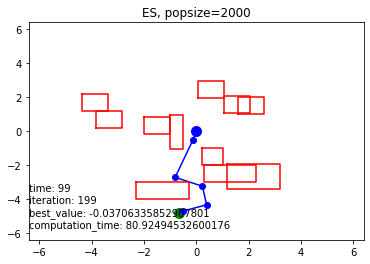

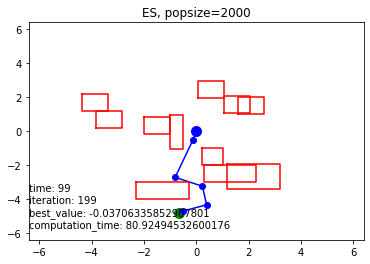

In [6]:
test_random(17)

Test 18


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.00133063, mean score = -6.33043206.
Iteration 0001 : best score = -0.00124801, mean score = -3.34113434.
Iteration 0002 : best score = -0.00133063, mean score = -2.61145290.
Iteration 0003 : best score = -0.00133063, mean score = -1.96836796.
Iteration 0004 : best score = -0.00133063, mean score = -1.58804929.
Iteration 0005 : best score = -0.00133063, mean score = -1.65415635.
Iteration 0006 : best score = -0.00133063, mean score = -1.42514576.
Iteration 0007 : best score = -0.00133063, mean score = -1.23607730.
Iteration 0008 : best score = -0.00133063, mean score = -1.43969848.
Iteration 0009 : best score = -0.00133063, mean score = -1.28611596.
Iteration 0010 : best score = -0.00133063, mean score = -1.13710706.
Iteration 0011 : best score = -0.00133063, mean score = -1.41018613.
Iteration 0012 : best score = -0.00133063, mean score = -1.24590728.
Iteration 0013 : best score = -0.00133063, mean score = -1.11728261.
Iteration 0014 : best score = -0.0

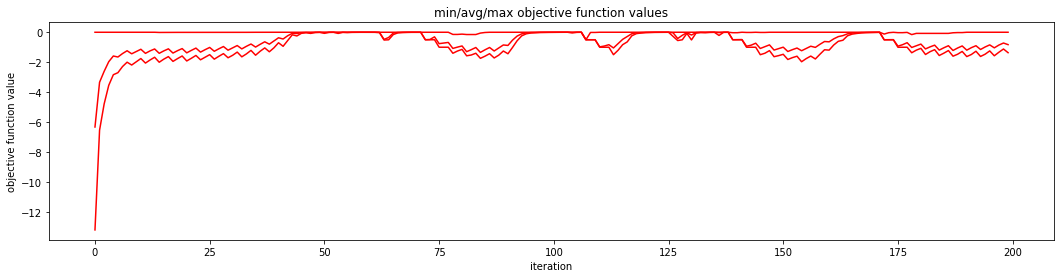

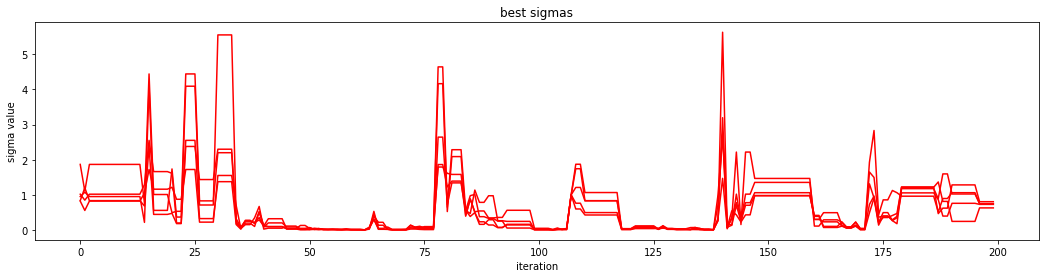

{'start_point': (0, 0), 'xlim': (-9.007242819323855, 9.007242819323855), 'ylim': (-9.007242819323855, 9.007242819323855), 'target_point': (3.038759517674462, -0.7343180995448062), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-9.007242819323855, 9.007242819323855), 'ylim': (-9.007242819323855, 9.007242819323855), 'target_point': (3.038759517674462, -0.7343180995448062), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


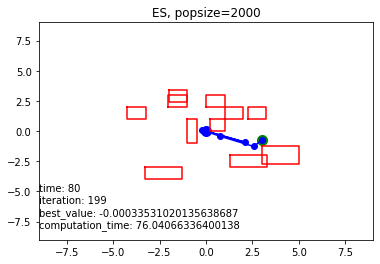

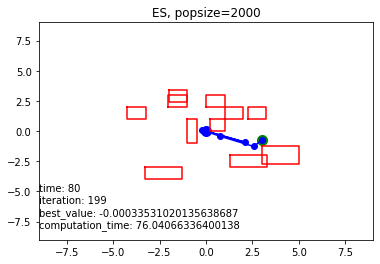

In [7]:
test_random(18)

Test 19


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.50494629, mean score = -7.82678851.
Iteration 0001 : best score = -0.49585184, mean score = -4.42033210.
Iteration 0002 : best score = -0.01942947, mean score = -3.41862129.
Iteration 0003 : best score = -0.01063584, mean score = -2.55483348.
Iteration 0004 : best score = -0.01063584, mean score = -2.09672743.
Iteration 0005 : best score = -0.00762773, mean score = -2.18098171.
Iteration 0006 : best score = -0.00762773, mean score = -1.92785982.
Iteration 0007 : best score = -0.00762773, mean score = -1.72003979.
Iteration 0008 : best score = -0.00762773, mean score = -1.94638793.
Iteration 0009 : best score = -0.00762773, mean score = -1.74616291.
Iteration 0010 : best score = -0.00762773, mean score = -1.59683017.
Iteration 0011 : best score = -0.00043526, mean score = -1.85827478.
Iteration 0012 : best score = -0.00043526, mean score = -1.68456651.
Iteration 0013 : best score = -0.00043526, mean score = -1.54886606.
Iteration 0014 : best score = -0.0

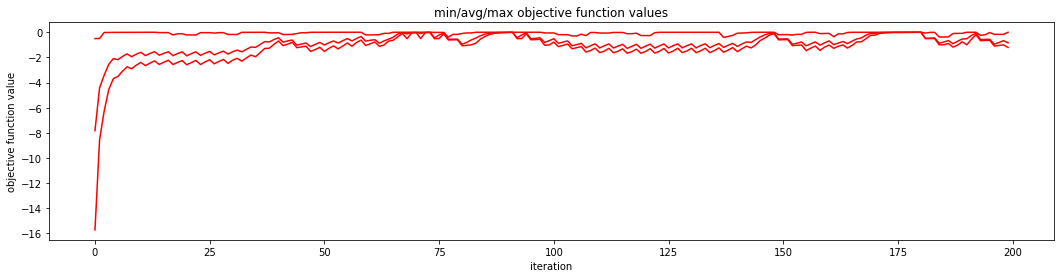

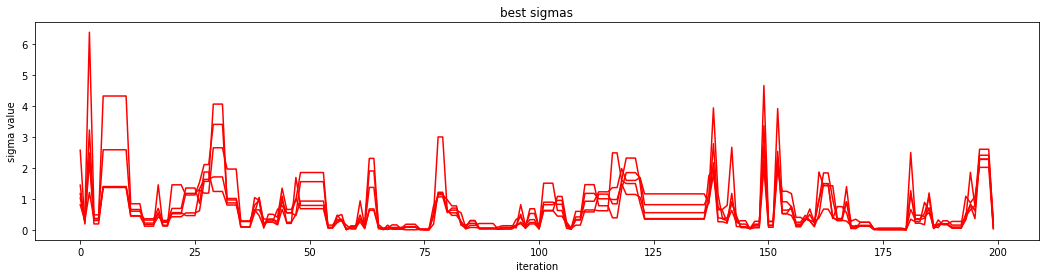

{'start_point': (0, 0), 'xlim': (-9.48788439467017, 9.48788439467017), 'ylim': (-9.48788439467017, 9.48788439467017), 'target_point': (2.673466908308823, 1.621257526530158), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-9.48788439467017, 9.48788439467017), 'ylim': (-9.48788439467017, 9.48788439467017), 'target_point': (2.673466908308823, 1.621257526530158), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


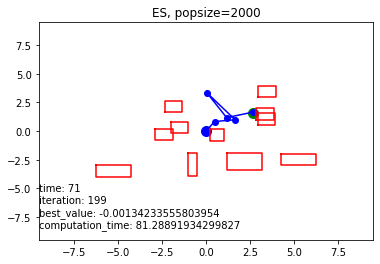

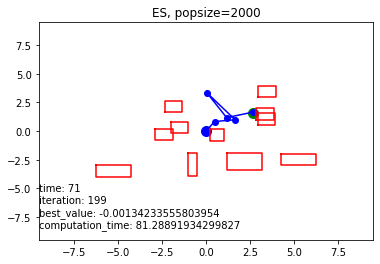

In [8]:
test_random(19)

Test 20


/home/martyna/Documents/studia/7semestr/Algorytmy ewolucyjne/projekt/algorytm.py:220: RuntimeWarning: divide by zero encountered in remainder
  if np.mod(self.iteration, self.iteration//10) == 0:


Iteration 0000 : best score = -0.00359539, mean score = -17.68037695.
Iteration 0001 : best score = -0.00359539, mean score = -9.63203688.
Iteration 0002 : best score = -0.01521059, mean score = -5.94944502.
Iteration 0003 : best score = -0.01521059, mean score = -3.60708515.
Iteration 0004 : best score = -0.01521059, mean score = -2.30946202.
Iteration 0005 : best score = -0.03823792, mean score = -2.15293561.
Iteration 0006 : best score = -0.02767520, mean score = -1.76270647.
Iteration 0007 : best score = -0.00168617, mean score = -1.48417310.
Iteration 0008 : best score = -0.00168617, mean score = -1.59125918.
Iteration 0009 : best score = -0.00168617, mean score = -1.35068553.
Iteration 0010 : best score = -0.00168617, mean score = -1.12743562.
Iteration 0011 : best score = -0.00168617, mean score = -1.20644401.
Iteration 0012 : best score = -0.00168617, mean score = -0.98721005.
Iteration 0013 : best score = -0.00168617, mean score = -0.76835738.
Iteration 0014 : best score = -0.

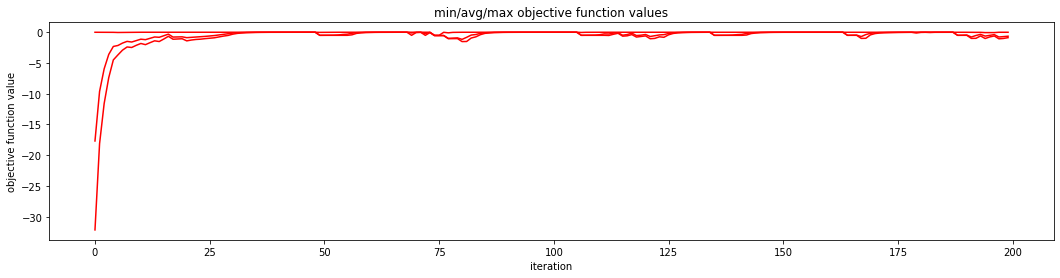

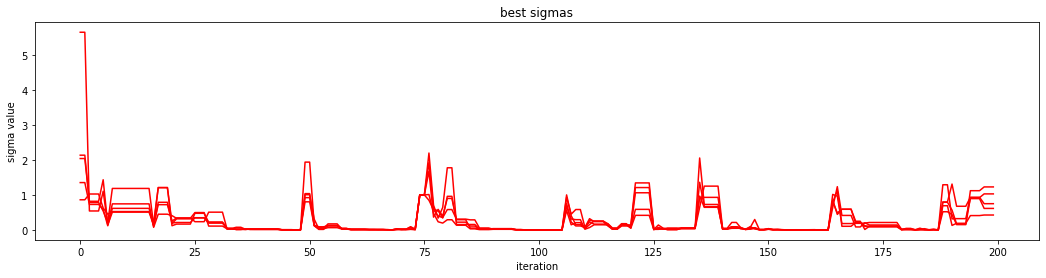

{'start_point': (0, 0), 'xlim': (-8.201633727767838, 8.201633727767838), 'ylim': (-8.201633727767838, 8.201633727767838), 'target_point': (-3.26492519255366, 5.138592276922378), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done
{'start_point': (0, 0), 'xlim': (-8.201633727767838, 8.201633727767838), 'ylim': (-8.201633727767838, 8.201633727767838), 'target_point': (-3.26492519255366, 5.138592276922378), 'title': 'ES, popsize=2000', 'text_keys': ['time', 'iteration', 'best_value', 'computation_time']}
Saving animation...Done


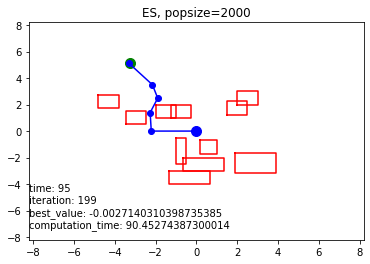

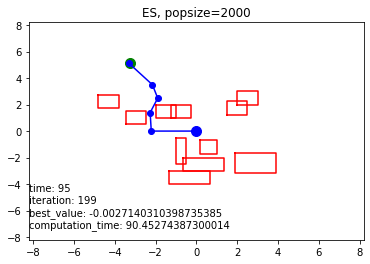

In [9]:
test_random(20)